In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython.display as ipd

In [3]:
frequency_sampling, audio_signal = wavfile.read("./vad_data/1447-130551-0017.wav")
print('\nSignal shape:', audio_signal.shape)
print('Signal Datatype:', audio_signal.dtype)
print('Signal duration:', round(audio_signal.shape[0] / 
float(frequency_sampling), 2), 'seconds')
print('sample rate: {}'.format(frequency_sampling))


Signal shape: (232160,)
Signal Datatype: int16
Signal duration: 14.51 seconds
sample rate: 16000


In [4]:
audio_signal = audio_signal / np.power(2, 15)
audio_signal = audio_signal [:100]
time_axis = 1000 * np.arange(0, len(audio_signal), 1) / float(frequency_sampling)

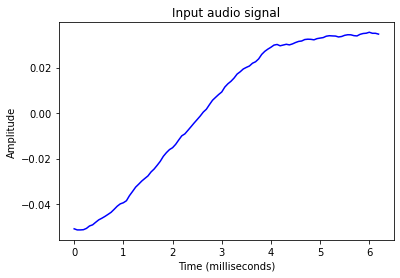

In [5]:
plt.plot(time_axis, audio_signal, color='blue')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.title('Input audio signal')
plt.show()

In [12]:
# time of audio
1/frequency_sampling * len(audio_signal)

0.00625

In [16]:
audio_data = './vad_data/1034-121119-0051.wav'
x , sr = librosa.load(audio_data)
start = 10
end = 11
seg_star = int(np.floor(start * sr))
seg_end = int(np.floor(end * sr))
ipd.Audio(data=x[seg_star:seg_end], rate=sr)

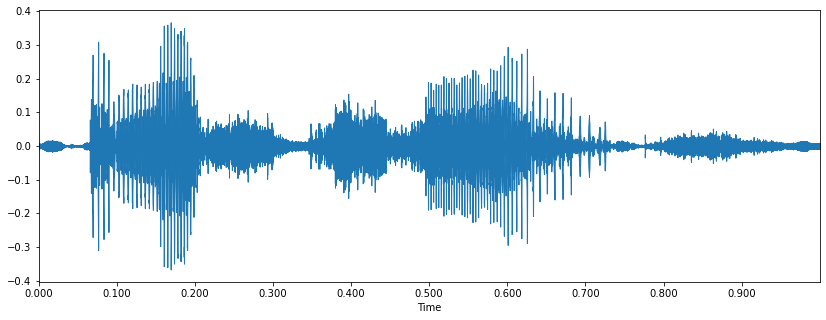

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[seg_star:seg_end], sr=sr)

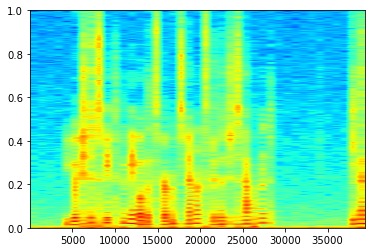

In [18]:
y, sr = librosa.load(audio_data, mono=True, duration=5, sr=16000)
plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='jet',
             sides='default', mode='default', scale='dB');

In [19]:
mfcc = librosa.feature.mfcc(x[seg_star:seg_end], sr, n_mfcc=13, n_fft=512 ,hop_length=128)
librosa.feature.delta(mfcc)

array([[ 0.8746908 ,  0.8746908 ,  0.8746908 , ..., -8.016322  ,
        -8.016322  , -8.016322  ],
       [-0.41103044, -0.41103044, -0.41103044, ..., -1.3777509 ,
        -1.3777509 , -1.3777509 ],
       [-3.3807411 , -3.3807411 , -3.3807411 , ...,  4.0468273 ,
         4.0468273 ,  4.0468273 ],
       ...,
       [-0.2699696 , -0.2699696 , -0.2699696 , ...,  0.7222117 ,
         0.7222117 ,  0.7222117 ],
       [-0.4693213 , -0.4693213 , -0.4693213 , ...,  2.9502723 ,
         2.9502723 ,  2.9502723 ],
       [ 0.96404135,  0.96404135,  0.96404135, ...,  0.85506886,
         0.85506886,  0.85506886]], dtype=float32)

# statistics of output dat

count    32560.000000
mean         0.292381
std          0.175828
min          0.010000
25%          0.150000
50%          0.250000
75%          0.400000
max          1.360000
Name: duration, dtype: float64

In [22]:
def extract_features(signal, sr=16000, n_mfcc=5, size=512, step=16, n_mels=40):
    mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=n_mfcc, n_fft=size, hop_length=step)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)

    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_mels=n_mels, n_fft=size, hop_length=step)
    rmse = librosa.feature.rms(S=mel_spectogram, frame_length=n_mels * 2 - 1, hop_length=step)

    mfcc, mfcc_delta, mfcc_delta_2, rmse = np.asarray(mfcc), np.asarray(mfcc_delta), np.asarray(mfcc_delta_2), np.asarray(rmse)
    # print(mfcc.shape, mfcc_delta.shape, mfcc_delta_2.shape, rmse.shape)
    features = np.concatenate((mfcc, mfcc_delta, mfcc_delta_2, rmse), axis=0)
    return features.transpose()

# nbseg = (seg_end - seg_star)//1024
# print(nbseg)
# data = []
# start = seg_star
# for seg in range(nbseg):
#     data.append(extract_features(x[start:start+1024]))
#     start += 1024

In [23]:
import tensorflow as tf
import numpy as np
import time
model = tf.keras.models.load_model('models/cnn.h5')

2022-02-06 12:12:50.832979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-06 12:12:50.833080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [26]:
%%time
data = np.random.rand(1, 65, 16, 1)
# s = time.time()
a = model.predict(data)
# print(time.time()-s)
a[0,0] + a[0, 1]
# Test time of run predict model

CPU times: user 43.8 ms, sys: 17.4 ms, total: 61.2 ms
Wall time: 57 ms


1.0

# Test with real-time data

In [31]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython
import os
import pyaudio
from gendata import extract_features
CHUNKSIZE = 1024 # fixed chunk size
RATE = 16000

# initialize portaudio
p = pyaudio.PyAudio()

In [30]:
%%time
extract_features(np.random.rand(1024,))
#test tiem of extract feature of samples

CPU times: user 121 ms, sys: 6.46 ms, total: 127 ms
Wall time: 30.2 ms


array([[-5.29876523e+01, -4.66258328e+00, -1.64946682e+00, ...,
        -1.81681719e-01,  5.86825585e-02,  3.89211226e-01],
       [-5.16831944e+01, -3.76975176e+00, -1.43627682e+00, ...,
        -1.81681719e-01,  5.86825585e-02,  3.87330054e-01],
       [-4.92143751e+01, -2.38397999e+00, -1.07360971e+00, ...,
        -1.81681719e-01,  5.86825585e-02,  3.82076138e-01],
       ...,
       [-6.18553799e+01, -9.33772642e+00,  3.69073010e+00, ...,
         8.23041299e-02, -1.56930941e-01,  3.14242898e-01],
       [-6.32013908e+01, -9.75870871e+00,  4.18082256e+00, ...,
         8.23041299e-02, -1.56930941e-01,  3.11988546e-01],
       [-6.37435455e+01, -9.98329869e+00,  4.34181225e+00, ...,
         8.23041299e-02, -1.56930941e-01,  3.11278827e-01]])

In [32]:
#Some Utils

def plotAudio(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    ax.margins(2, -0.1)
    plt.show()

# Plot audio
def plotAudio2(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    plt.show()

def minMaxNormalize(arr):
    mn = np.min(arr)
    mx = np.max(arr)
    return (arr-mn)/(mx-mn)

def predictSound(X):
    features = extract_features(X)
    result = model.predict(np.array([features]))
#     predictions = [np.argmax(y) for y in result]
#     print(predictions)
    return result[0][1]#np.argmax(result)

In [33]:
stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

for i in range(100):
    # Read chunk and load it into numpy array.
    data = stream.read(CHUNKSIZE, exception_on_overflow = False)
    current_window = np.frombuffer(data, dtype=np.float32)
    
    #Reduce noise real-time
#     current_window = reduce_noise(audio_clip=current_window, noise_clip=noise_sample, verbose=False)
    
    print(predictSound(current_window), end=' ## ')

# close stream
stream.stop_stream()
stream.close()
p.terminate()

2022-02-06 12:15:17.718156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1.0638181e-15 ## 0.0002810843 ## 0.0020936767 ## 1.2674046e-06 ## 2.969926e-07 ## 1.2013056e-10 ## 1.5747689e-07 ## 0.049848348 ## 3.115198e-06 ## 0.98977494 ## 1.0 ## 1.0 ## 1.2613871e-10 ## 1.0 ## 1.0 ## 1.0 ## 1.0 ## 0.9999975 ## 0.0033455128 ## 1.0247279e-05 ## 4.4586503e-08 ## 3.9411287e-07 ## 8.794961e-08 ## 3.9619317e-07 ## 3.4219103e-11 ## 2.6806148e-08 ## 3.5132489e-10 ## 1.819467e-07 ## 9.370321e-10 ## 1.0870004e-06 ## 9.90637e-06 ## 0.00033274098 ## 0.16379118 ## 0.015329483 ## 1.6447992e-12 ## 1.1693637e-09 ## 2.1675488e-09 ## 6.9625805e-10 ## 4.8005e-06 ## 1.0996626e-13 ## 2.0740009e-11 ## 1.0 ## 1.0 ## 1.9250237e-08 ## 2.2070966e-05 ## 0.9999999 ## 1.0 ## 0.9999982 ## 0.99989843 ## 2.9687517e-06 ## 1.0646044e-06 ## 0.8859558 ## 0.5306605 ## 0.00031673716 ## 1.7365527e-06 ## 1.8097437e-07 ## 5.8973573e-09 ## 2.1049837e-08 ## 3.5710244e-07 ## 1.2754225e-06 ## 1.0 ## 0.9999988 ## 1.0 ## 1.0 ## 1.0 ## 1.0 ## 0.9999999 ## 1.0 ## 0.99999905 ## 0.9999999 ## 1.0 ## 1.0 ## 0.99999

In [34]:
from jupyterplot import ProgressPlot
import numpy as np

# pp = ProgressPlot()
pp = ProgressPlot(plot_names=["Silero VAD"],line_names=["speech probabilities"], x_label="audio chunks")
for i in range(20):
    x = 0 if np.random.rand() < 0.5 else 1
    pp.update(x)
pp.finalize()

In [35]:
from jupyterplot import ProgressPlot
import threading

continue_recording = True

def stop():
    input("Press Enter to stop the recording:")
    global continue_recording
    continue_recording = False

def start_recording():
    
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

    data = []
    voiced_confidences = []
    
    global continue_recording
    continue_recording = True
    
    pp = ProgressPlot(plot_names=["Voice Activity Detection"],line_names=["speech probabilities"], x_label="audio chunks")
    
    stop_listener = threading.Thread(target=stop)
    stop_listener.start()

    while continue_recording:
    
        data = stream.read(CHUNKSIZE, exception_on_overflow = False)
        current_window = np.frombuffer(data, dtype=np.float32)    
        # get the confidences and add them to the list to plot them later
        new_confidence = predictSound(current_window)
#         print(new_confidence)
        pp.update(float(new_confidence))


    pp.finalize()

In [36]:
start_recording()

Press Enter to stop the recording:
